In [1]:
import numpy as np
import networkx as nx
import copy
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
# "the default sans-serif font is Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 10})

In [3]:
import pickle

- **Data preparation**

In [15]:
# The cities, nodes represent cities in this order
Cities = ['Houston', 'Dallas', 'Oklahoma City', 'Kansas City', 'Memphis', 'Birmingham', 'New Orleans']
# Define the network through an adjacent matrix
AM = np.array([[0, 1, 0, 0, 0, 0, 1 ], [1, 0, 1, 0, 1, 0, 1], [0, 1, 0, 1, 1, 0, 0], [0, 0, 1, 0, 1, 0, 0],
               [0, 1, 1, 1, 0, 1, 1], [0, 0, 0, 0, 1, 0, 1], [1, 1, 0, 0, 1, 1, 0]])

# The coordinate information of modes, the third dimension is eliminated
XYs = [[0, 0], [0, 5], [-0.5, 10], [0.5, 15], [5, 5.5], [10, 5], [5, 0]]

- **Build networkx object and specify basic settings**

In [35]:
# Buidl networkx netowrk object from adjacent matrix 
Graph = nx.from_numpy_matrix(AM)
Nodes = list(Graph.nodes())
Edges = list(Graph.edges())
Source = Nodes[4]
Terminal = Nodes[0]
# Assign failure probability to each edge, 0.125, 0.01
Failprob = [0.01] * len(Edges)
# Define a dictionary to represent the link fail probabilti mapping
Zipobj = zip(Edges, Failprob)
Edgesfailprob = dict(Zipobj)

- **Calculate $S-T$ reliability through counting**

In [17]:
def connectstate(graph, source, terminal, edgesfailprob):
    # Initial state variable for the network
    state = 0
    edges = list(edgesfailprob.keys())
    numberofedges = len(edges)
    # Make a deepcopy of the graph
    graphdc = copy.deepcopy(graph)
    # Simulate failure state of each link
    randomnumber = np.random.uniform(0, 1, numberofedges)
    failedges = []
    for k in range(numberofedges):
        # Compare the random number with the fail probability of each link
        if randomnumber[k] <= edgesfailprob[edges[k]]:
            failedges.append(edges[k])
    # Modify the orignal graph by deleting the failed links
    for edge in failedges:
        (u, v) = edge
        graphdc.remove_edge(u, v)
    # Check if source is connected with terminals
    # Use BFS to get all the nodes that connected to source
    sucnodes = list( dict(nx.bfs_successors(graphdc,source)).values() )
    # Reoganize sucnodes (list of list) as a simple list
    reachablenodes = [j for i in sucnodes for j in i]
    # Check if the terminal IS in the successors of source
    if terminal in reachablenodes:
        state = 1
    return state

In [18]:
# Implement the GBAS algorithm
def GBAS(k, graph, source, terminal, edgesfailprob):
    # Initialize variable
    scount = 0
    qcount = 0
    samplesize = 0
    while scount < k:
        # Repeat MCS
        scount += connectstate(graph, source, terminal, edgesfailprob)
        qcount += np.random.exponential(scale = 1.0, size = 1)[0]
        samplesize += 1
    r = (k-1)/qcount
    return r, samplesize 

In [19]:
# Implement the AA
# Stopping Rule Algorithm (SRA)
def SRA(epsilon, delta, graph, source, terminal, edgesfailprob):
    # General parameters for all time instant
    lamda = np.exp(1) - 2
    gama = 4 * lamda * np.log(2/delta) / (epsilon**2)
    gama1 = (1 + (1 + epsilon) * gama)
    # Initialize variable
    sumx = 0
    count = 0
    samplex = []
    while sumx < gama1:
        # Sample 
        x = connectstate(graph, source, terminal, edgesfailprob)
        sumx += x
        count += 1
        samplex.append(x)
    mimux = gama1/count
    return mimux, count, samplex
 

In [20]:
# AA to determine the sample size
def AA(epsilon, delta, graph, source, terminal, edgesfailprob):
    # General parameters for all time instant
    lamda = np.exp(1) - 2
    gama = 4 * lamda * np.log(2/delta) / (epsilon**2)
    gama2 = gama * 2 * (1 + np.sqrt(epsilon)) * (1 + 2 * np.sqrt(epsilon)) * (1+np.log(3/2)/np.log(2/delta))
    
    # Step1, implement SRA 
    # Parameters
    epsilonsra = np.min( np.array([1/2, np.sqrt(epsilon)]) )
    deltasra = delta/3
    # The sample in this step will be used later
    miuxsra, countsra, samplexsra = SRA(epsilonsra, deltasra, graph, source, 
                                        terminal, edgesfailprob)
    
    # Step2
    # Get the essential number to evaluate rol for each instant
    # Initialize data and get the sample size for step 2
    rol = 0
    n3 = 0 # The final sample size from the AA 
    n2 = int(np.ceil(gama2 * epsilon / miuxsra))
    sumsig = 0
    samplexstep2 = []
    # Sample the maximum number of realizations to calculate rol
    for i in range(n2):
        # Sample
        x1 = connectstate(graph, source, terminal, edgesfailprob)
        x2 = connectstate(graph, source, terminal, edgesfailprob)
        samplexstep2.append(x1)
        samplexstep2.append(x2)
        sumsig += (x1-x2)**2 / 2
    # Calculate the n3
    rol = max([sumsig/n2, epsilon*miuxsra])
    n3 = int(np.ceil(gama2 * rol / (miuxsra**2)))
                 
    # Step3
    # Check if the sample size in previous step is enough for Step3
    samplepre = samplexsra + samplexstep2
    if len(samplepre) < n3:
        # Generate extra samples
        for j in range(len(samplepre), n3):
            x = connectstate(graph, source, terminal, edgesfailprob)
            samplepre.append(x)        
    # Calculate the reliability at each timestep for each node
    rel = sum(samplepre[0:n3])/n3
    return rel, n3

In [21]:
Epsilon = 0.05
Delta = 0.05

In [51]:
# Set the number of samples
NS = 3000
# k parameter for GBAS
K = 1550
Sampleset = []
Samplesizeset = []
for j in range(NS):
    R, Samplesize = GBAS(K, Graph, Source, Terminal, Edgesfailprob)
    #R, Samplesize = AA(Epsilon, Delta, Graph, Source, Terminal, Edgesfailprob)
    Sampleset.append(R)
    Samplesizeset.append(Samplesize)

In [52]:
# Save the sampleset
FSampleset = open('GBAS3000Updatesampleset.pickle','wb')
pickle.dump(Sampleset,FSampleset)
FSampleset.close()
FSamplesizeset = open('GBAS3000UpdateSamplesizeset.pickle','wb')
pickle.dump(Samplesizeset,FSamplesizeset)
FSamplesizeset.close()

In [53]:
# Load the sampleset
FSampleset = open('GBAS3000Updatesampleset.pickle','rb')
Sampleset = pickle.load(FSampleset)
FSampleset.close()

In [54]:
# Calculate empirical CDF of the sampleset
def ecdf(sampleset):
    # First get the frequency count
    sval, scounts = np.unique(sampleset, return_counts=True)
    srelfre = scounts/np.sum(scounts)
    scdf = np.zeros(len(srelfre))
    for i in range(len(srelfre)):
        scdf[i] = np.sum(srelfre[0: i+1])
    return sval, scdf      

In [55]:
Sval, Scdf = ecdf(Sampleset)

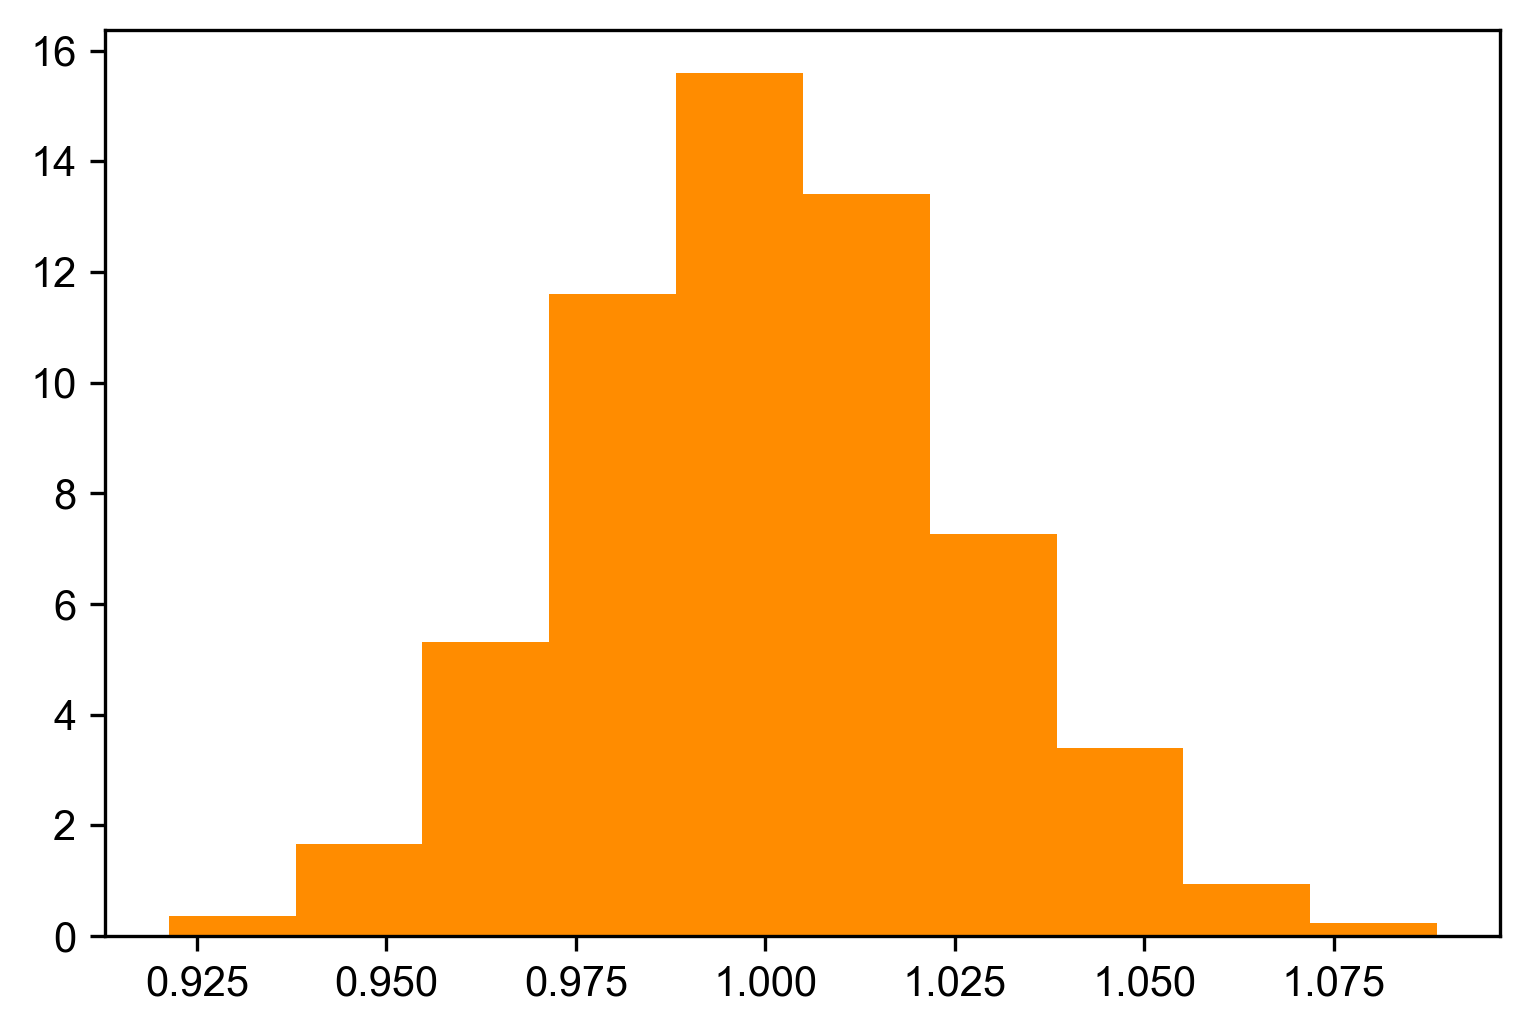

In [56]:
# Visualize the relative frequency histogram darkorange
plt.hist(Sampleset, density=True, color='darkorange')
plt.rcParams['figure.figsize'] = (6, 4) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.savefig(r"%s.jpg"%('GBASFrequencyHis001'), bbox_inches='tight')
plt.show()

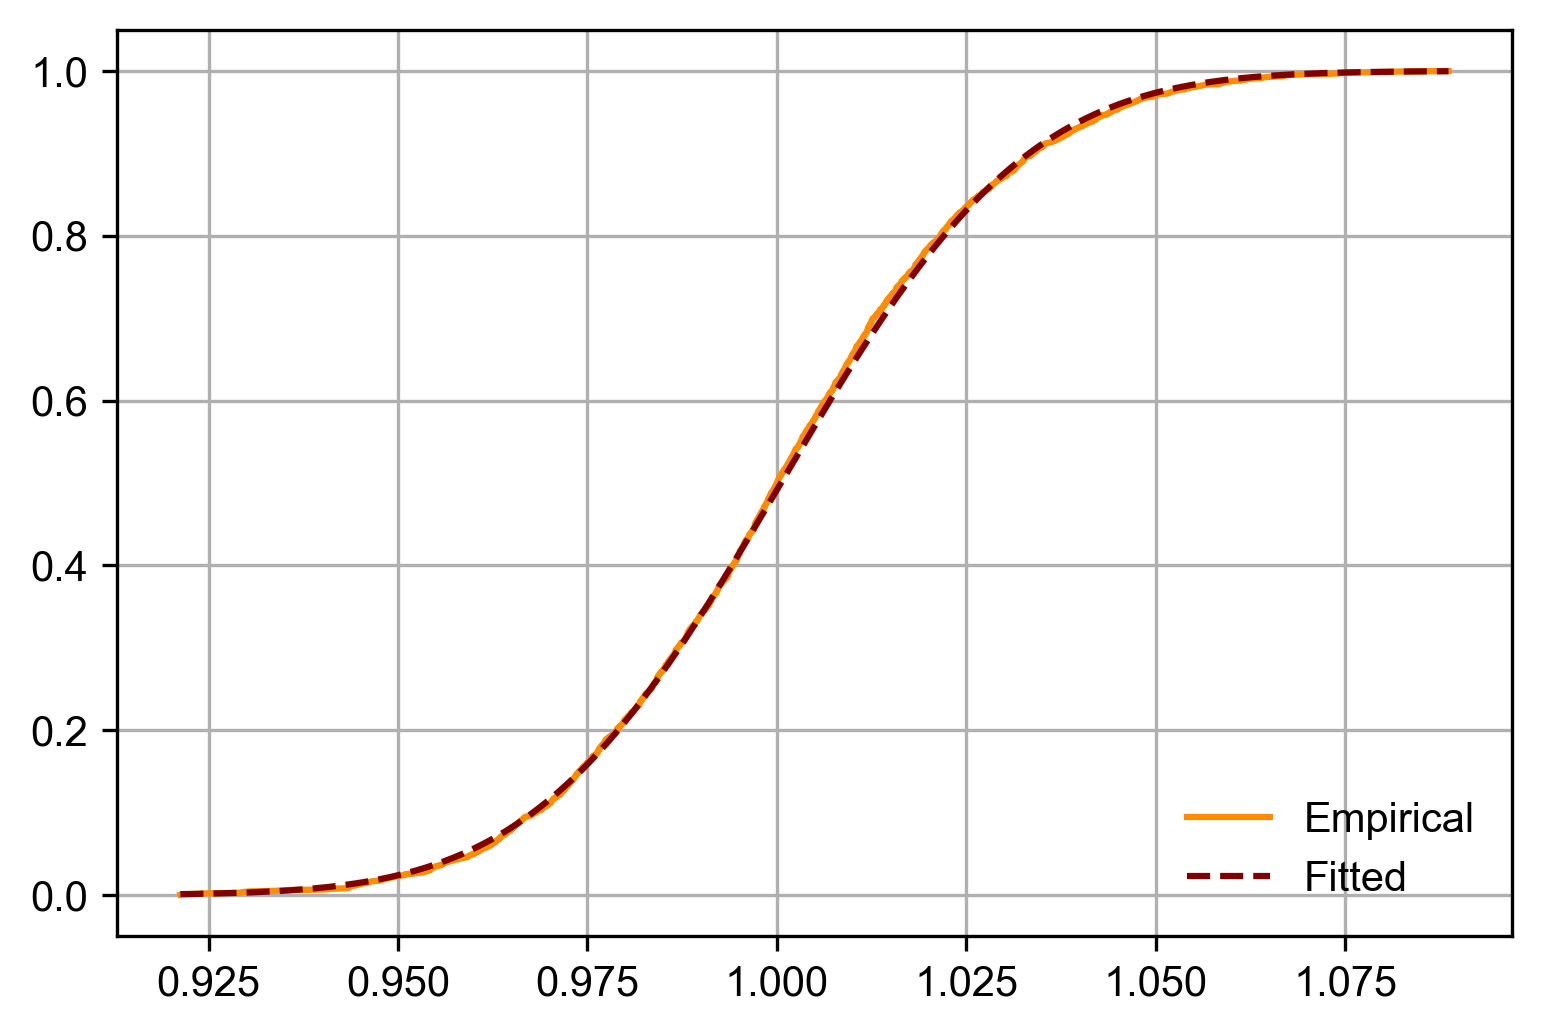

In [57]:
# Visualize the empirical distribution of estimation of R
# First plot the frequency density histogram and fit the distribution
Miu = np.mean(Sampleset)
Sig = np.std(Sampleset)
Cdffit = stats.distributions.norm.cdf(Sval, Miu, Sig)
plt.plot(Sval, Scdf, color='darkorange', label='Empirical') #seagreen darkorange
plt.plot(Sval, Cdffit, '--', color='maroon', label='Fitted')
plt.legend(loc='lower right', frameon=False)
plt.grid(True)
plt.rcParams['figure.figsize'] = (6, 4) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.savefig(r"%s.jpg"%('GBAS3000Update Goodness of fit'), bbox_inches='tight')
plt.show()

In [58]:
# Perform KS test
# Calculate the maximum discrepancy
Discrepancy = np.abs(Cdffit-Scdf)
Dmax = np.max(Discrepancy)
Dmax

0.017414376003671905

In [13]:
print(1.3581/np.sqrt(3000))

0.02479540017825887


In [31]:
Miu, Sig

(0.9832201472620915, 0.004376318400556425)

In [33]:
# Visualize relative error
FSamplesetAA = open('AA553000Updatesampleset.pickle','rb')
SamplesetAA = np.array(pickle.load(FSamplesetAA))
FSamplesetAA.close()
FSamplesetGBAS = open('GBAS3000sampleset.pickle','rb')
SamplesetGBAS = np.array(pickle.load(FSamplesetGBAS))
FSamplesetGBAS.close()
# Calculate the relative error
Exact = 0.983189
Relative_error1 = (SamplesetAA - Exact) / Exact
Relative_error2 = (SamplesetGBAS - Exact) / Exact

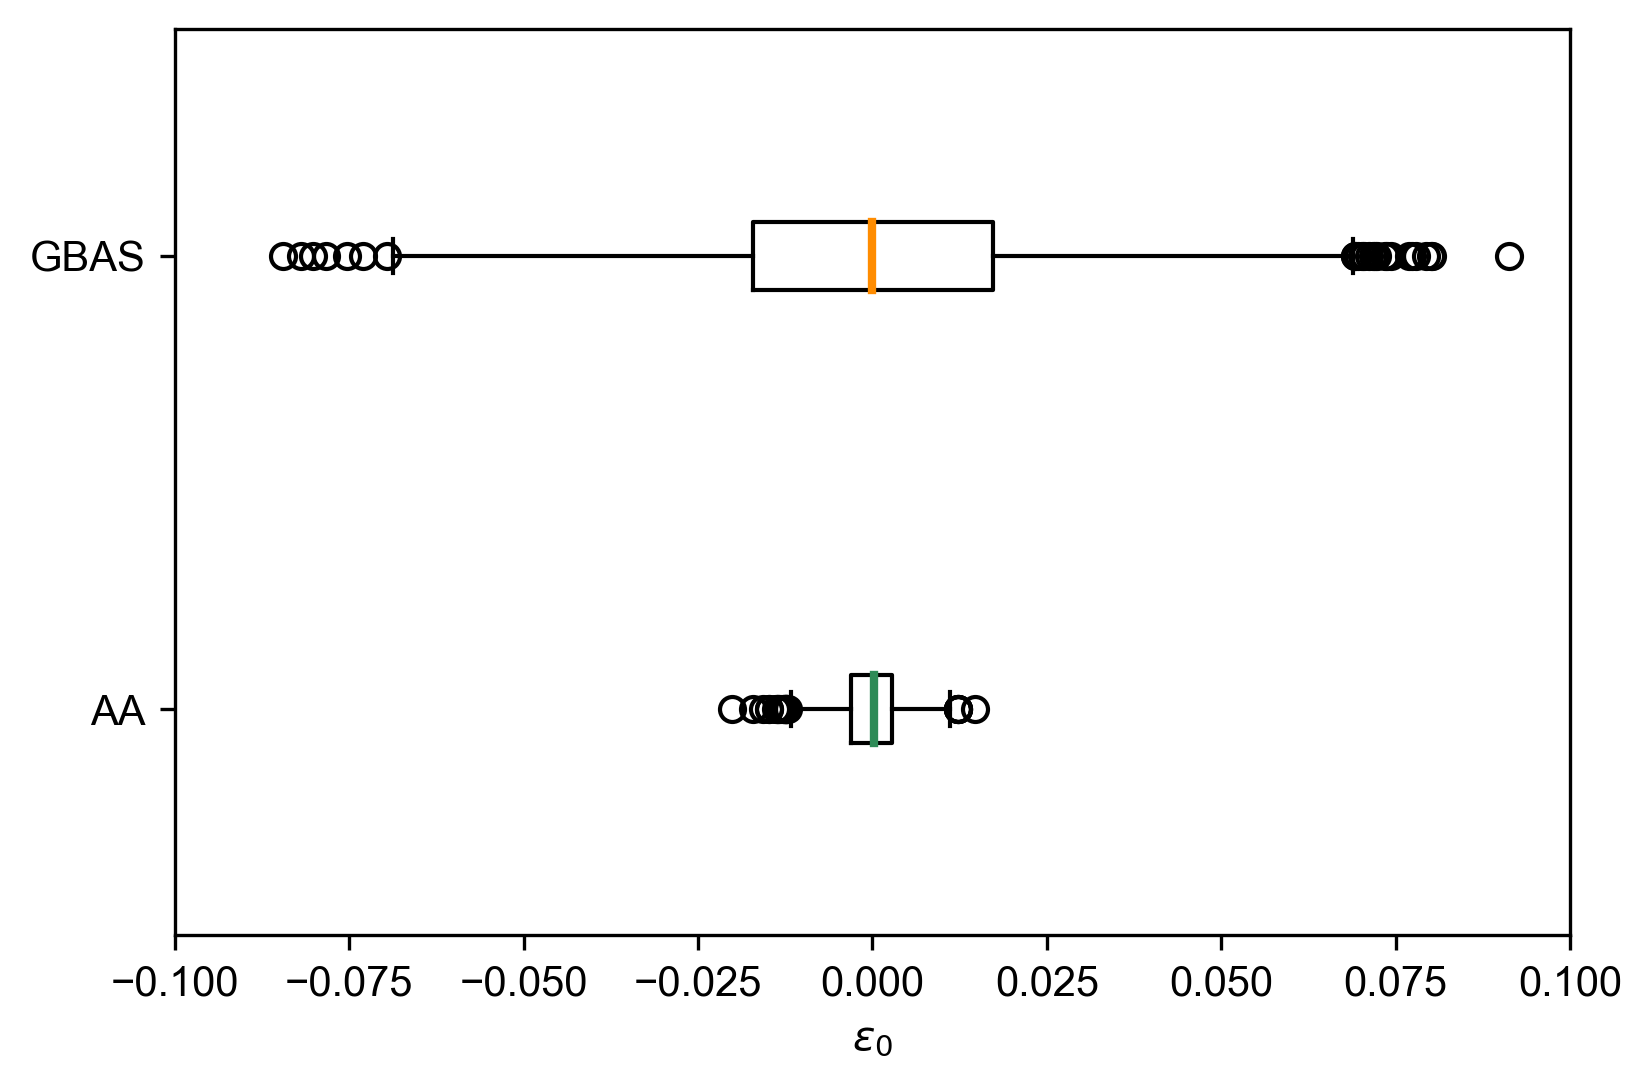

In [34]:
# Visualize the relative error
f, ax = plt.subplots()
Data = [Relative_error1, Relative_error2]
# plot the same data on both axes
Bp = plt.boxplot(Data, vert = 0)  
Colors = ['seagreen', 'darkorange'] 
# changing color and linewidth of medians 
i = 0
for median in Bp['medians']: 
    median.set(color = Colors[i], linewidth = 2)
    i += 1    
plt.xlim(-0.1, 0.1)
# ax2.yaxis.tick_right()
ax.set_yticklabels(['AA', 'GBAS'])
plt.xlabel('$\epsilon_0$')
plt.rcParams['figure.figsize'] = (6, 4) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
plt.savefig(r"%s.jpg" % ('Relativeerror_boxplotUpdate'), bbox_inches='tight')
plt.show()

In [41]:
# Check with the built in test function in scipy
Statistic, Crival, Sigle = stats.anderson(SamplesetAA, dist='norm')

In [42]:
Statistic, Crival, Sigle

(8.213276670158848,
 array([0.575, 0.655, 0.786, 0.917, 1.091]),
 array([15. , 10. ,  5. ,  2.5,  1. ]))